Luca Dal Zotto
1236343

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: extend the notebook used in Lab 07, in order to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Try to tune the model hyperparameters or tweak the reward function in order to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).
*	3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.
*	3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms:
https://gym.openai.com/envs 



## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

# Import

Install gym

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # used to implement the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [552 kB]
Get:

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        # Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) ) 

    def sample(self, batch_size):
        # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        batch_size = min(batch_size, len(self)) 
        # Randomly select "batch_size" samples
        return random.sample(self.memory, batch_size) 

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each). 

Be sure to keep a linear output activation: the Q-value can be any number!

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

I modified the exploration profile by changing the decay rate, the initial value, and also making it non-monotonic.

Monotonic case:

$$f(x)=t_{0} \cdot r a t e^{x},$$

Non-monotonic case:

$$f(x)=\frac{t_{0} \cdot r a t e^{x}+t_{0}\left[-\sin \left(\frac{\pi \cdot x}{T}\right)+1\right] \cdot r a t e_{2}^{x}}{2}.$$

In [ ]:
def exploration_profile(num_iterations, initial_value, rate=0.99, period=0, rate2=0.994):

    ep = [initial_value * (rate ** i) for i in range(num_iterations)]
    
    if period != 0:
        p = period/2
        ep = [( exp + initial_value * (-np.sin(np.pi * i/p) + 1) * (rate2 ** i))/2 for i,exp in enumerate(ep)]

    return ep

Let's make some plot

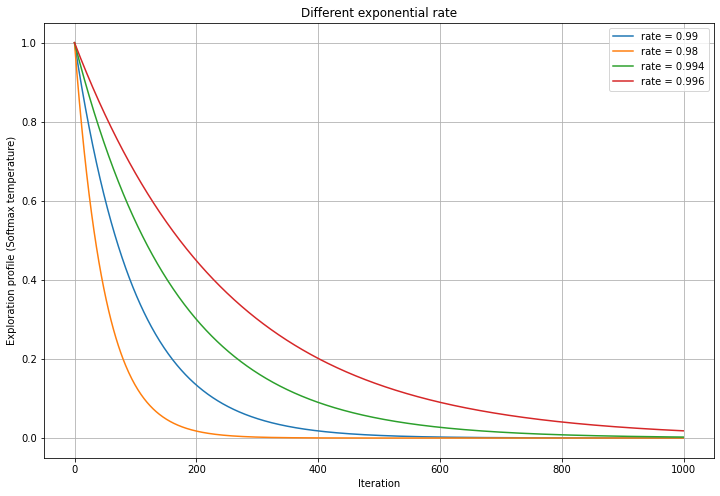

In [ ]:
# Different exponential rate
ep = exploration_profile(1000, 1, rate=0.99)
ep1 = exploration_profile(1000, 1, rate=0.994)
ep2 = exploration_profile(1000, 1, rate=0.996)
ep3 = exploration_profile(1000, 1, rate=0.98)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'rate = 0.99')
plt.plot(ep3, label = 'rate = 0.98')
plt.plot(ep1, label = 'rate = 0.994')
plt.plot(ep2, label = 'rate = 0.996')
plt.grid()
plt.title('Different exponential rate')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.legend()
plt.show()

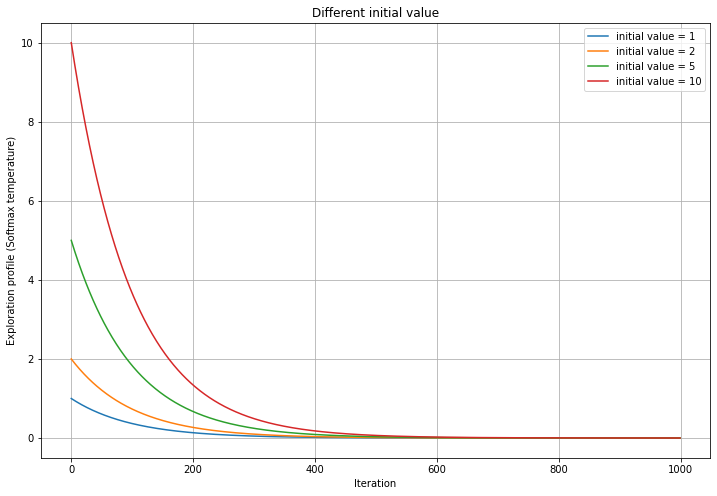

In [ ]:
# Different initial value
ep = exploration_profile(1000, 1, rate=0.99)
ep1 = exploration_profile(1000, 2, rate=0.99)
ep2 = exploration_profile(1000, 5, rate=0.99)
ep3 = exploration_profile(1000, 10, rate=0.99)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'initial value = 1')
plt.plot(ep1, label = 'initial value = 2')
plt.plot(ep2, label = 'initial value = 5')
plt.plot(ep3, label = 'initial value = 10')
plt.grid()
plt.title('Different initial value')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
plt.legend()
plt.show()

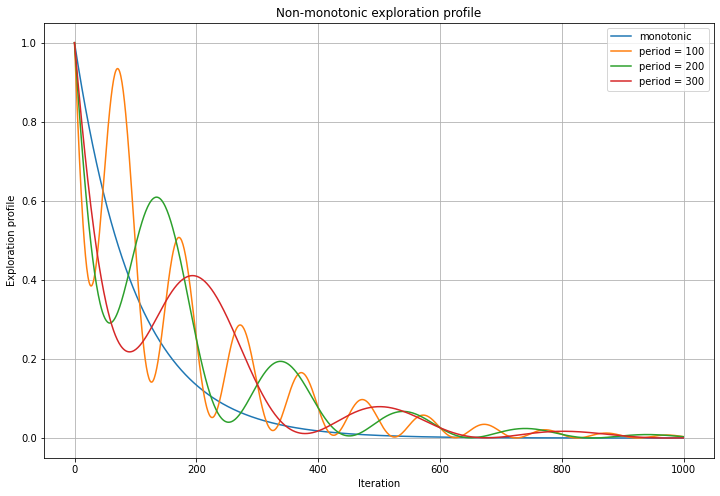

In [ ]:
# Non-monotonic exploration profile
ep = exploration_profile(1000, 1, rate=0.99, period=0, rate2=0.994)
ep1 = exploration_profile(1000, 1, rate=0.99, period=100, rate2=0.995)
ep2 = exploration_profile(1000, 1, rate=0.99, period=200, rate2=0.995)
ep3 = exploration_profile(1000, 1, rate=0.99, period=300, rate2=0.995)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'monotonic')
plt.plot(ep1, label = 'period = 100')
plt.plot(ep2, label = 'period = 200')
plt.plot(ep3, label = 'period = 300')
plt.grid()
plt.title('Non-monotonic exploration profile')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.legend()
plt.show()

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

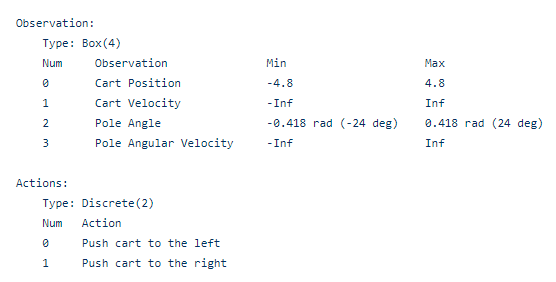

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the s### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")tate space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [ ]:
# env.reset()
# env.step(0)

# Auxiliary functions

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

## Training loop

In [ ]:
min_samples_for_training = 1000 # Minimum samples in the replay memory to enable the training
batch_size = 128 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(state_space_dim, action_space_dim)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            if penalization == 'position':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0]) 
            
            elif penalization == 'angle':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 10
                reward = reward - pos_weight * np.abs(state[2])

            elif penalization == 'both':
                # We apply a (linear) penalty when the cart is far from center
                reward = reward - np.abs(state[0]) - 10 * np.abs(state[2]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 20 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # Reset the environment and get the initial state
                state = env.reset()
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    next_state, reward, done, info = env.step(action)
                    # Visually render the environment
                    # env.render()
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # Set the current state for the next iteration
                    state = next_state
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
                score_log.append(score)
            avg_score = np.mean(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    return test_score_log, episode_num+1
    # return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

# Exploring the marginal effects of the hyper-parameters

### Exploration policy

#### Epsilon-greedy

Changing rate

In [ ]:
rate_v = [0.99, 0.98, 0.994, 0.996]
results={}
for rate in rate_v:
    print(f'rate: {rate}')
    key = 'eps-' + str(rate)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        penalization='position', exp_policy='epsilon-greedy', initial_value=1, rate=rate, period=0)
    print()

rate: 0.99


Game solved after 180 training episodes

rate: 0.98


Game solved after 300 training episodes

rate: 0.994


Game solved after 840 training episodes

rate: 0.996


Game solved after 380 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

eps-0.99 -> 180 episodes
eps-0.98 -> 300 episodes
eps-0.994 -> 840 episodes
eps-0.996 -> 380 episodes


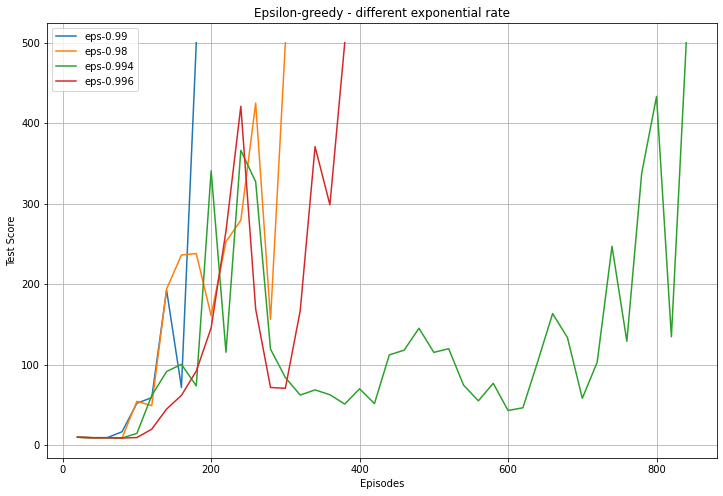

In [ ]:
plt.figure(figsize=(12,8))
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Epsilon-greedy - different exponential rate')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

Changing period

In [ ]:
period_v = [100, 200, 300]
results={}
for period in period_v:
    print(f'period: {period}')
    key = 'eps-' + str(period)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        penalization='position', exp_policy='epsilon-greedy', initial_value=1, rate=0.99, period=period)
    print()

period: 100


Game solved after 340 training episodes

period: 200


Game NOT solved after 1000 training episodes. Best score: 474.4


period: 300


Game solved after 260 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

eps-100 -> 340 episodes
eps-200 -> 1000 episodes
eps-300 -> 260 episodes


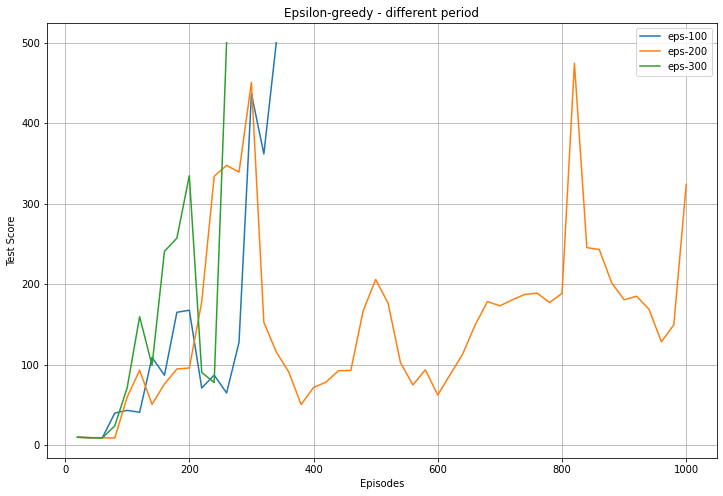

In [ ]:
plt.figure(figsize=(12,8))
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Epsilon-greedy - different period')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

#### Softmax

Changing rate

In [ ]:
rate_v = [0.99, 0.98, 0.994, 0.996]
results={}
for rate in rate_v:
    print(f'rate: {rate}')
    key = 'softmax-' + str(rate)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        penalization='position', exp_policy='softmax', initial_value=1, rate=rate, period=0)
    print()

rate: 0.99


Game solved after 740 training episodes

rate: 0.98


Game solved after 600 training episodes

rate: 0.994


Game solved after 920 training episodes

rate: 0.996


Game solved after 780 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

softmax-0.99 -> 740 episodes
softmax-0.98 -> 600 episodes
softmax-0.994 -> 920 episodes
softmax-0.996 -> 780 episodes


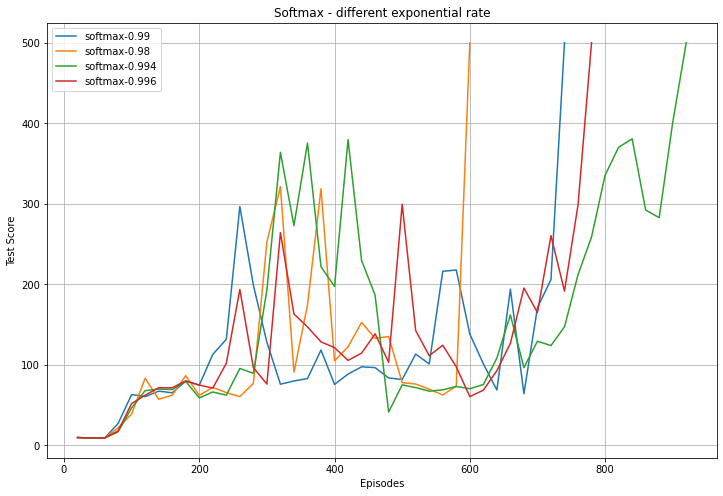

In [ ]:
plt.figure(figsize=(12,8))
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Softmax - different exponential rate')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

In [ ]:
ref = results['softmax-0.99']
print(ref)

([9.8, 9.2, 9.2, 27.2, 63.2, 60.6, 67.4, 65.4, 79.8, 74.8, 113.0, 131.8, 296.6, 199.0, 128.0, 76.0, 80.0, 83.0, 118.4, 75.8, 88.6, 97.6, 96.6, 83.8, 81.8, 113.4, 101.2, 216.2, 217.8, 138.4, 101.4, 68.8, 194.0, 64.2, 171.0, 206.0, 500.0], 740)


Changing initial_value

In [ ]:
initial_value_v = [2, 5, 10]
results={}
for initial_value in initial_value_v:
    print(f'initial_value: {initial_value}')
    key = 'softmax-' + str(initial_value)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        penalization='position', exp_policy='softmax', initial_value=initial_value, rate=0.99, period=0)
    print()

initial_value: 2


Game solved after 940 training episodes

initial_value: 5


Game solved after 800 training episodes

initial_value: 10


Game solved after 380 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

softmax-2 -> 940 episodes
softmax-5 -> 800 episodes
softmax-10 -> 380 episodes


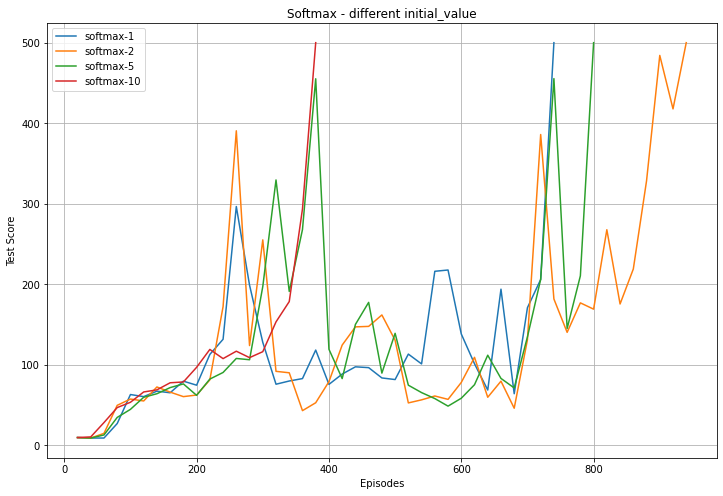

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'softmax-1')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Softmax - different initial_value')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

Changing period

In [ ]:
period_v = [100, 200, 300]
results={}
for period in period_v:
    print(f'period: {period}')
    key = 'softmax-' + str(period)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=period)
    print()

period: 100


Game solved after 260 training episodes

period: 200


Game solved after 820 training episodes

period: 300


Game solved after 840 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

softmax-100 -> 260 episodes
softmax-200 -> 820 episodes
softmax-300 -> 840 episodes


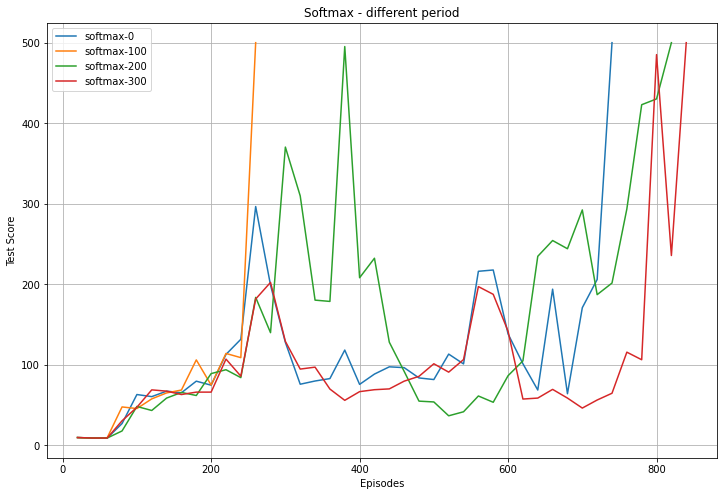

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'softmax-0')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Softmax - different period')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

## Other hyper-parameters

#### Gamma

In [ ]:
gamma_v = [0.94, 0.9, 0.99]
results={}
for gamma in gamma_v:
    print(f'gamma: {gamma}')
    key = 'gamma-' + str(gamma)
    results[key] = main(iter=1000, gamma=gamma, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

gamma: 0.94


Game NOT solved after 1000 training episodes. Best score: 439.0


gamma: 0.9


Game NOT solved after 1000 training episodes. Best score: 274.0


gamma: 0.99


Game solved after 720 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

gamma-0.94 -> 1000 episodes
gamma-0.9 -> 1000 episodes
gamma-0.99 -> 720 episodes


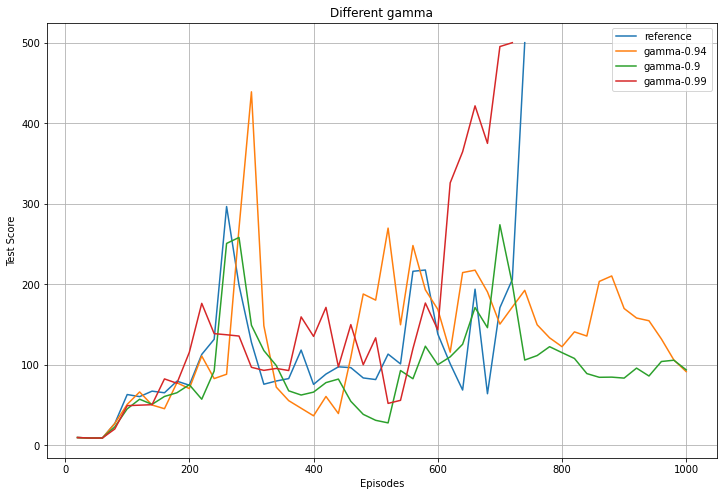

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'reference')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different gamma')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

#### Reward function

In [ ]:
penalization_v = ['position', 'angle', 'both', False]
results={}
for penalization in penalization_v:
    print(f'penalization: {penalization}')
    key = 'penalization-' + str(penalization)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        bad_state_penalty=0, penalization=penalization, exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

penalization: position


Game solved after 740 training episodes

penalization: angle


Game solved after 300 training episodes

penalization: both


Game solved after 380 training episodes

penalization: False


Game NOT solved after 1000 training episodes. Best score: 491.8




In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

penalization-position -> 740 episodes
penalization-angle -> 300 episodes
penalization-both -> 380 episodes
penalization-False -> 1000 episodes


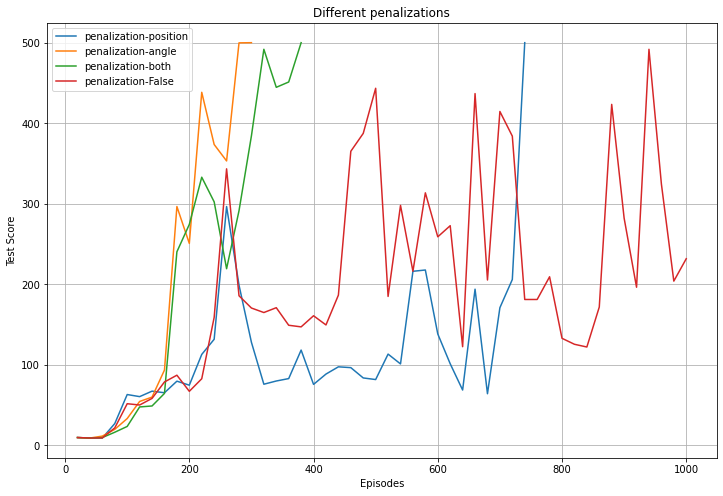

In [ ]:
plt.figure(figsize=(12,8))
# plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'reference')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different penalizations')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

#### bad_state_penalty

In [ ]:
bad_state_penalty_v = [1,2,5]
results={}
for bad_state_penalty in bad_state_penalty_v:
    print(f'bad_state_penalty: {bad_state_penalty}')
    key = 'bad_state_penalty-' + str(bad_state_penalty)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
                        bad_state_penalty=bad_state_penalty, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

bad_state_penalty: 1


Game solved after 840 training episodes

bad_state_penalty: 2


Game solved after 580 training episodes

bad_state_penalty: 5


Game solved after 580 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

bad_state_penalty-1 -> 840 episodes
bad_state_penalty-2 -> 580 episodes
bad_state_penalty-5 -> 580 episodes


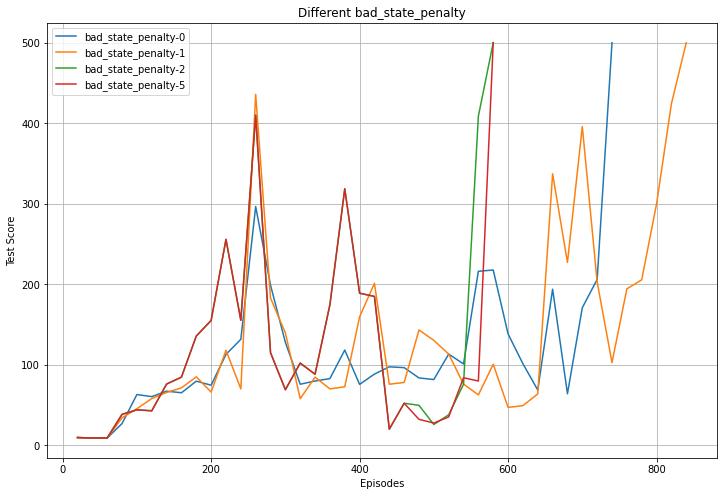

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'bad_state_penalty-0')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different bad_state_penalty')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

#### replay_memory_capacity

In [ ]:
# replay_memory_capacity_v = [1000, 10000, 100000]
replay_memory_capacity_v = [5000, 20000, 50000, 100000]
results={}
for replay_memory_capacity in replay_memory_capacity_v:
    print(f'replay_memory_capacity: {replay_memory_capacity}')
    key = 'replay_memory_capacity-' + str(replay_memory_capacity)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=replay_memory_capacity, lr=1e-2, target_net_update_steps=10, 
                        bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

replay_memory_capacity: 5000


Game solved after 620 training episodes

replay_memory_capacity: 20000


Game solved after 260 training episodes

replay_memory_capacity: 50000


Game solved after 260 training episodes

replay_memory_capacity: 100000


Game solved after 260 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

replay_memory_capacity-5000 -> 620 episodes
replay_memory_capacity-20000 -> 260 episodes
replay_memory_capacity-50000 -> 260 episodes
replay_memory_capacity-100000 -> 260 episodes


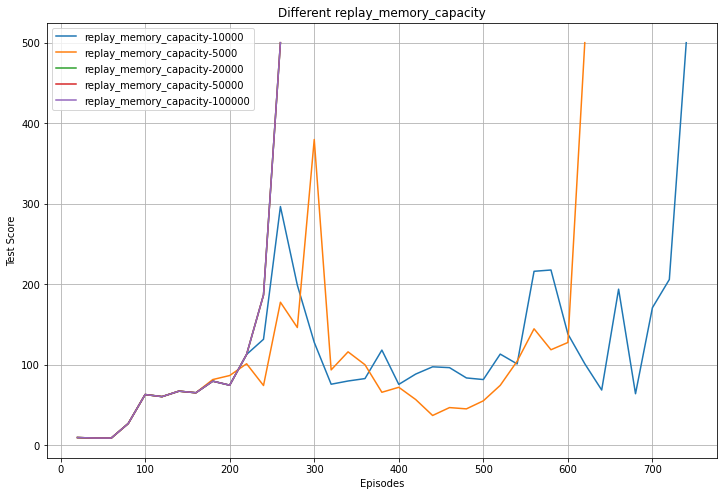

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'replay_memory_capacity-10000')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different replay_memory_capacity')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

In [ ]:
# ref = results['replay_memory_capacity-10000']

#### target_net_update_steps

In [ ]:
# target_net_update_steps_v = [1, 20, 50]
target_net_update_steps_v = [1, 2, 5, 20]
results={}
for target_net_update_steps in target_net_update_steps_v:
    print(f'target_net_update_steps: {target_net_update_steps}')
    key = 'target_net_update_steps-' + str(target_net_update_steps)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=target_net_update_steps, 
                        bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

target_net_update_steps: 1


Game solved after 280 training episodes

target_net_update_steps: 2


Game solved after 420 training episodes

target_net_update_steps: 5


Game solved after 680 training episodes

target_net_update_steps: 20


Game solved after 300 training episodes



In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

target_net_update_steps-1 -> 280 episodes
target_net_update_steps-2 -> 420 episodes
target_net_update_steps-5 -> 680 episodes
target_net_update_steps-20 -> 300 episodes


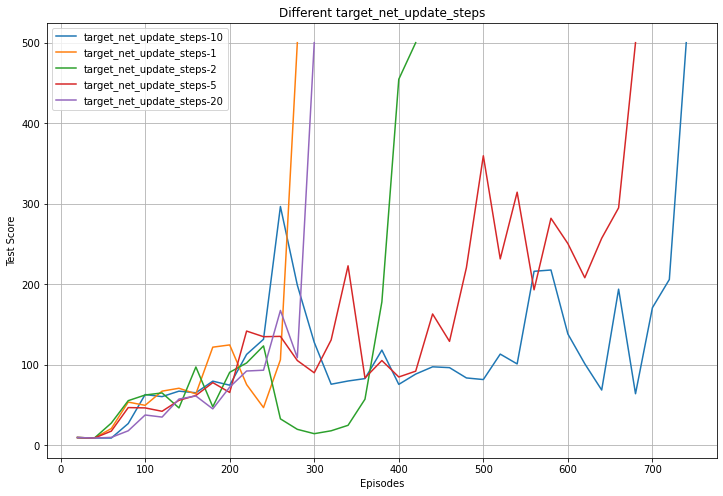

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'target_net_update_steps-10')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different target_net_update_steps')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

#### Learning rate

In [ ]:
lr_v = [1, 1e-1, 1e-3]
results={}
for lr in lr_v:
    print(f'lr: {lr}')
    key = 'lr-' + str(lr)
    results[key] = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=lr, target_net_update_steps=10, 
                        bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0)
    print()

lr: 1


Game solved after 640 training episodes

lr: 0.1


Game solved after 220 training episodes

lr: 0.001


Game NOT solved after 1000 training episodes. Best score: 67.2




In [ ]:
for k,v in results.items():
    print(f'{k} -> {v[1]} episodes')

lr-1 -> 640 episodes
lr-0.1 -> 220 episodes
lr-0.001 -> 1000 episodes


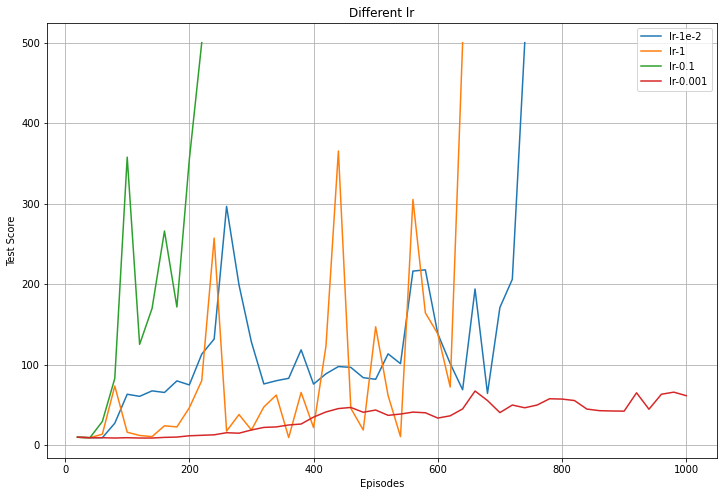

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(20, ref[1]+20, 20), ref[0], label = 'lr-1e-2')
for k in results.keys():
    plt.plot(np.arange(20,results[k][1]+20,20), results[k][0], label = k)
plt.grid()
plt.title('Different lr')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.show()

# Complete optimization

In this final section, I performed a small grid search considering only the most promising hyper-parameter combiantions.

## softmax

In [ ]:
# min_samples_for_training = 1000 # Minimum samples in the replay memory to enable the training
batch_size = 128 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, msft=1000):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(state_space_dim, action_space_dim)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            if penalization == 'position':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0]) 
            
            elif penalization == 'angle':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 10
                reward = reward - pos_weight * np.abs(state[2])

            elif penalization == 'both':
                # We apply a (linear) penalty when the cart is far from center
                reward = reward - np.abs(state[0]) - 10 * np.abs(state[2]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > msft: 
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        # Print the final score
        # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 10 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # Reset the environment and get the initial state
                state = env.reset()
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    next_state, reward, done, info = env.step(action)
                    # Visually render the environment
                    # env.render()
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # Set the current state for the next iteration
                    state = next_state
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
                score_log.append(score)
            avg_score = np.mean(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
pbar = tqdm(total = 72, desc = 'Optimization')
for rate in [0.98, 0.99]:
  for initial_value in [1, 10]:
    for period in [0, 100]:
      for tnus in [1, 2, 5]: # target_net_update_steps
        for lr in [1, 1e-1, 1e-2]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, period: {period}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, T:{period}, ts:{tnus}, lr:{lr}'

          score_log, ep_num, _ = main(iter=400, gamma=0.97, replay_memory_capacity=20000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=5, penalization='both', exp_policy='softmax', 
                                   initial_value=initial_value, rate=rate, period=period, msft=1000)
          results.append((key, ep_num, score_log))
          print()
          pbar.update(1)

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 130 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 90 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 160 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 170 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 240 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 140 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 200 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 130 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 190 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 190 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 150 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 210 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 150 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 80 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 160 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 90 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 310 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 200 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 70 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 270 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 160 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 80 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 310 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 150 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 180 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 210 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 80 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 100 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 200 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 150 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 90 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 210 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 230 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 210 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 150 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 200 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 110 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 150 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 150 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 150 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 200 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 200 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 160 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 250 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 170 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 130 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 250 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 190 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 80 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 280 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 240 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 230 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 350 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 340 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 80 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.01



Game solved after 250 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 240 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 90 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 190 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 350 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 230 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 380 training episodes



In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:10]
print(best)

[('b:0.98, t0:10, T:100, ts:1, lr:0.1', 70, [9.6, 9.4, 9.4, 9.8, 9.6, 125.6, 500.0]), ('b:0.98, t0:10, T:0, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 11.8, 89.8, 150.2, 500.0]), ('b:0.98, t0:10, T:100, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 114.6, 157.2, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:1', 80, [9.6, 9.4, 9.4, 9.8, 22.2, 134.2, 213.2, 500.0]), ('b:0.99, t0:10, T:0, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 131.4, 147.4, 500.0]), ('b:0.99, t0:10, T:100, ts:1, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 11.0, 126.4, 179.2, 500.0]), ('b:0.98, t0:1, T:0, ts:1, lr:0.1', 90, [9.6, 9.4, 9.4, 9.8, 9.2, 17.0, 476.2, 370.2, 500.0]), ('b:0.98, t0:10, T:0, ts:5, lr:0.1', 90, [9.6, 9.4, 9.4, 9.8, 9.2, 103.6, 98.0, 110.0, 500.0]), ('b:0.99, t0:1, T:0, ts:2, lr:0.1', 90, [9.6, 9.4, 9.4, 9.8, 11.2, 63.4, 202.6, 221.2, 500.0]), ('b:0.99, t0:10, T:100, ts:2, lr:0.1', 90, [9.6, 9.4, 9.4, 9.8, 9.2, 151.2, 176.4, 403.4, 500.0])]


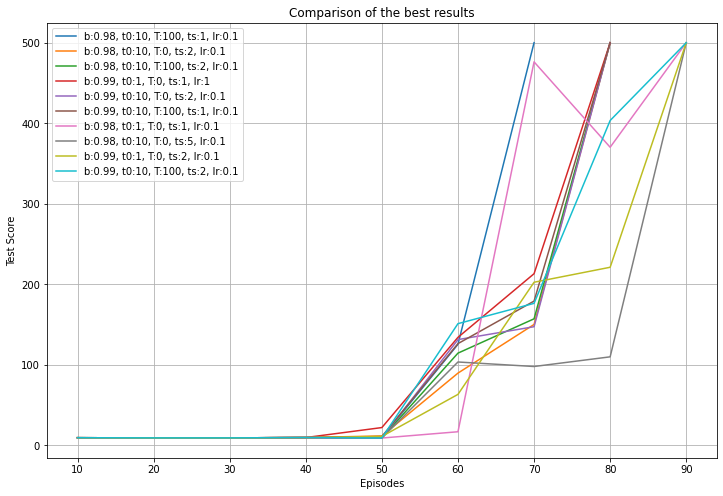

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('softmax10.png')
plt.show()

In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:5]
print(best)

[('b:0.98, t0:10, T:100, ts:1, lr:0.1', 70, [9.6, 9.4, 9.4, 9.8, 9.6, 125.6, 500.0]), ('b:0.98, t0:10, T:0, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 11.8, 89.8, 150.2, 500.0]), ('b:0.98, t0:10, T:100, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 114.6, 157.2, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:1', 80, [9.6, 9.4, 9.4, 9.8, 22.2, 134.2, 213.2, 500.0]), ('b:0.99, t0:10, T:0, ts:2, lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 131.4, 147.4, 500.0])]


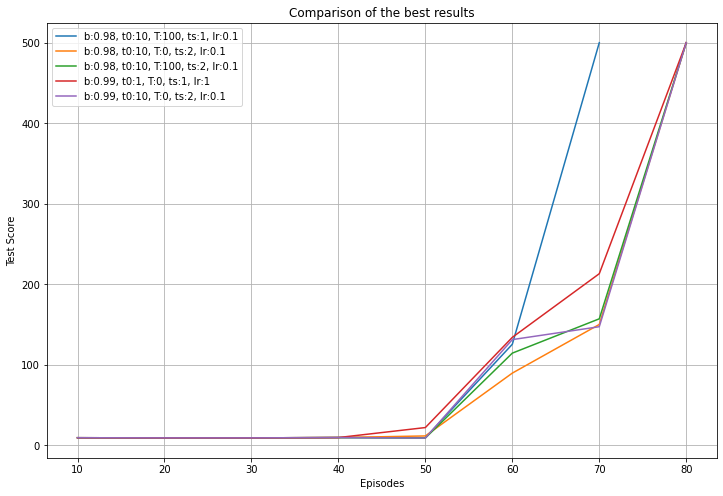

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('softmax5.png')
plt.show()

From these results, we can see that the learning actually starts after the 40th episode, since we set min_samples_for_training = 1000. Let's see if we can decrease this parameter and still guarantee learning stability.

In [ ]:
# min_samples_for_training = 256 # Minimum samples in the replay memory to enable the training

results = []
pbar = tqdm(total = 72, desc = 'Optimization')
for rate in [0.98, 0.99]:
  for initial_value in [1, 10]:
    for period in [0, 100]:
      for tnus in [1, 2, 5]: # target_net_update_steps
        for lr in [1, 1e-1, 1e-2]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, period: {period}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, T:{period}, ts:{tnus}, lr:{lr}'

          score_log, ep_num, _ = main(iter=400, gamma=0.97, replay_memory_capacity=20000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=5, penalization='both', exp_policy='softmax', 
                                   initial_value=initial_value, rate=rate, period=period, msft=256)
          results.append((key, ep_num, score_log))
          print()
          pbar.update(1)

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 110 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 300 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 100 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 270 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 130 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 140 training episodes

rate: 0.98, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 400 training episodes. Best score: 493.4


rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 100 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 90 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 150 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 150 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 60 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 200 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 110 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 120 training episodes

rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 250 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 210 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 150 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 110 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 130 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 240 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 160 training episodes

rate: 0.98, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 240 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 230 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 30 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 140 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 180 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 300 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 170 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 210 training episodes

rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 180 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 70 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 70 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 140 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 120 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 90 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 120 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 110 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 130 training episodes

rate: 0.99, initial_value: 1, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 190 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 50 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 80 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 100 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 190 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 70 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 170 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 130 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 80 training episodes

rate: 0.99, initial_value: 1, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 210 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 1


Game solved after 160 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.1


Game solved after 110 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 1, lr: 0.01


Game solved after 250 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 1


Game solved after 200 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.1


Game solved after 150 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 2, lr: 0.01


Game solved after 280 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 1


Game solved after 280 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.1


Game solved after 210 training episodes

rate: 0.99, initial_value: 10, period: 0, target_net_update_steps: 5, lr: 0.01


Game solved after 360 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 1


Game solved after 220 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.1


Game solved after 150 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.01


Game solved after 280 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 1


Game solved after 260 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.1


Game solved after 180 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 2, lr: 0.01


Game solved after 280 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 1


Game solved after 250 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.1


Game solved after 180 training episodes

rate: 0.99, initial_value: 10, period: 100, target_net_update_steps: 5, lr: 0.01


Game solved after 200 training episodes



In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:10]
print(best)

[('b:0.98, t0:10, T:100, ts:1, lr:0.1', 30, [9.6, 347.6, 500.0]), ('b:0.99, t0:1, T:100, ts:1, lr:1', 50, [9.6, 35.6, 198.4, 451.6, 500.0]), ('b:0.98, t0:1, T:100, ts:2, lr:0.1', 60, [9.6, 47.6, 374.8, 222.0, 298.4, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:1', 70, [9.6, 275.8, 99.0, 192.4, 138.6, 14.2, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:0.1', 70, [9.6, 98.6, 128.2, 189.8, 335.8, 398.4, 500.0]), ('b:0.99, t0:1, T:100, ts:2, lr:0.1', 70, [9.6, 47.6, 150.4, 240.0, 218.6, 282.8, 500.0]), ('b:0.99, t0:1, T:100, ts:1, lr:0.1', 80, [9.6, 49.4, 244.2, 271.2, 248.8, 382.8, 320.4, 500.0]), ('b:0.99, t0:1, T:100, ts:5, lr:0.1', 80, [9.6, 9.4, 42.2, 213.8, 373.0, 360.4, 444.6, 500.0]), ('b:0.98, t0:1, T:100, ts:1, lr:0.1', 90, [9.6, 69.2, 313.0, 290.2, 322.4, 441.4, 302.2, 469.8, 500.0]), ('b:0.99, t0:1, T:0, ts:2, lr:0.1', 90, [9.6, 66.4, 82.0, 160.4, 198.2, 248.6, 195.4, 306.6, 500.0])]


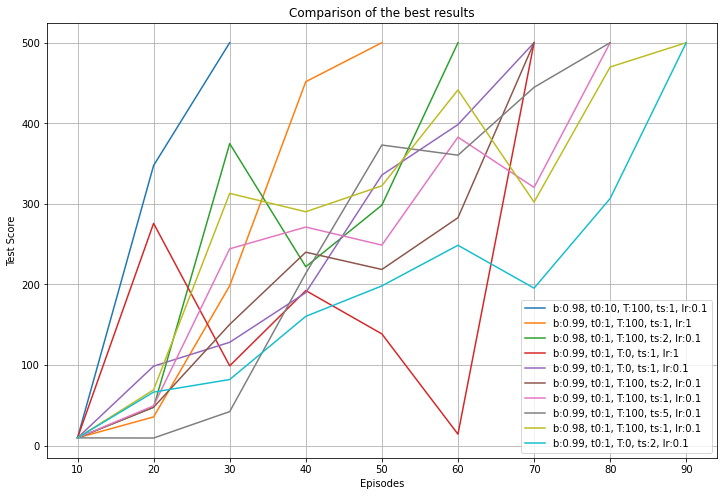

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('softmax10.png')
plt.show()

In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:5]
print(best)

[('b:0.98, t0:10, T:100, ts:1, lr:0.1', 30, [9.6, 347.6, 500.0]), ('b:0.99, t0:1, T:100, ts:1, lr:1', 50, [9.6, 35.6, 198.4, 451.6, 500.0]), ('b:0.98, t0:1, T:100, ts:2, lr:0.1', 60, [9.6, 47.6, 374.8, 222.0, 298.4, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:1', 70, [9.6, 275.8, 99.0, 192.4, 138.6, 14.2, 500.0]), ('b:0.99, t0:1, T:0, ts:1, lr:0.1', 70, [9.6, 98.6, 128.2, 189.8, 335.8, 398.4, 500.0])]


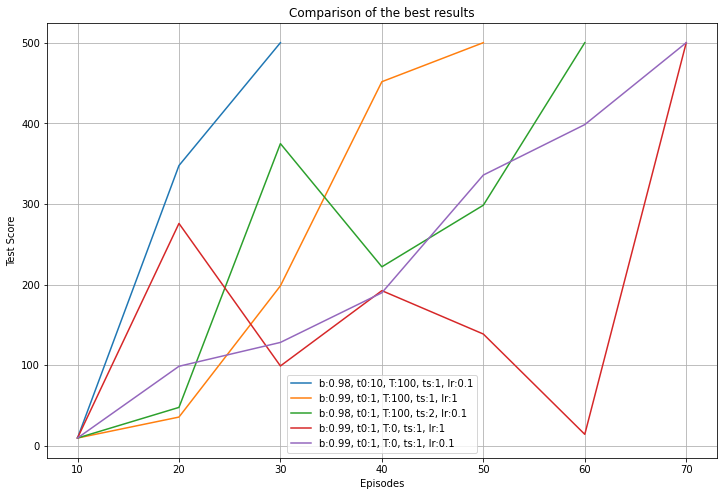

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('softmax5.png')
plt.show()

### Additional tests

Fastest solution: 30 episodes

In [ ]:
# rate: 0.98, initial_value: 10, period: 100, target_net_update_steps: 1, lr: 0.1 -> 30
score_log, ep_num, policy_net = main(iter=400, gamma=0.97, replay_memory_capacity=10000, lr=0.1, target_net_update_steps=1, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=10, rate=0.98, period=100, msft=256)

Game solved after 30 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(5): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()


TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 335
TEST EPISODE 4 - FINAL SCORE: 195
TEST EPISODE 5 - FINAL SCORE: 361
Average test score (over 5 runs): 378.2


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.67.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.67.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.67.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.67.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.67.video000004.mp4


Probably this was a lucky combination, since these additional test results are not good. Let's consider another combination.

60 episodes

In [ ]:
# rate: 0.98, initial_value: 1, period: 100, target_net_update_steps: 2, lr: 0.1 -> 60
score_log, ep_num, policy_net = main(iter=400, gamma=0.97, replay_memory_capacity=10000, lr=0.1, target_net_update_steps=2, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=1, rate=0.98, period=100, msft=256)

Game solved after 60 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
TEST EPISODE 6 - FINAL SCORE: 500
TEST EPISODE 7 - FINAL SCORE: 500
TEST EPISODE 8 - FINAL SCORE: 500
TEST EPISODE 9 - FINAL SCORE: 500
TEST EPISODE 10 - FINAL SCORE: 500
Average test score (over 5 runs): 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.1.67.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000001.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000002.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000003.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000004.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000005.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000006.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000007.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000008.mp4



SHOWING VIDEO video/openaigym.video.1.67.video000009.mp4


## epsilon-greedy

In [ ]:
results = []
pbar = tqdm(total = 64, desc = 'Optimization')

for rate in [0.98, 0.99]:
  for gamma in [0.97, 0.99]:
    for period in [0, 100]:
      for tnus in [1, 5]: # target_net_update_steps
        for msft in [500, 1000]: # min_samples_for_training
          for lr in [1, 1e-1]: 

            print(f'rate: {rate}, gamma:{gamma}, period: {period}, target_net_update_steps: {tnus}, min_samples_for_training: {msft}, lr: {lr}')
            key = f'b:{rate}, gamma:{gamma}, T:{period}, ts:{tnus}, ms:{msft} lr:{lr}'

            score_log, ep_num, _ = main(iter=400, gamma=gamma, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                    bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                    initial_value=1, rate=rate, period=period, msft=msft)
            results.append((key, ep_num, score_log))
            print()
            pbar.update(1)

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 130 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 110 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 150 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 70 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 150 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 80 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 190 training episodes

rate: 0.98, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 160 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game NOT solved after 400 training episodes. Best score: 388.0


rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 150 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 310 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 160 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 230 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 150 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 280 training episodes

rate: 0.98, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 80 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 220 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 60 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 220 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 90 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 160 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 310 training episodes

rate: 0.98, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 190 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 260 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 150 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 180 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 130 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 310 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 180 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 210 training episodes

rate: 0.98, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 80 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 270 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 180 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 190 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 150 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 260 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 270 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 80 training episodes

rate: 0.99, gamma:0.97, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 210 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 310 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 190 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 190 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 180 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 390 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 40 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 250 training episodes

rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 210 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 330 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 170 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 280 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 160 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 210 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 210 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 240 training episodes

rate: 0.99, gamma:0.99, period: 0, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 190 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 1


Game solved after 290 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 500, lr: 0.1


Game solved after 170 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 1


Game solved after 240 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 1, min_samples_for_training: 1000, lr: 0.1


Game solved after 160 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 1


Game solved after 310 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1


Game solved after 40 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 1


Game solved after 240 training episodes

rate: 0.99, gamma:0.99, period: 100, target_net_update_steps: 5, min_samples_for_training: 1000, lr: 0.1


Game solved after 220 training episodes



In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:10]
print(best)

[('b:0.99, gamma:0.97, T:100, ts:5, ms:500 lr:0.1', 40, [9.6, 9.4, 46.4, 500.0]), ('b:0.99, gamma:0.99, T:100, ts:5, ms:500 lr:0.1', 40, [9.6, 9.4, 38.2, 500.0]), ('b:0.98, gamma:0.99, T:0, ts:1, ms:500 lr:0.1', 60, [9.6, 9.4, 9.4, 20.8, 72.4, 500.0]), ('b:0.98, gamma:0.97, T:0, ts:1, ms:1000 lr:0.1', 70, [9.6, 9.4, 9.4, 9.8, 9.2, 98.2, 500.0]), ('b:0.98, gamma:0.97, T:0, ts:5, ms:500 lr:0.1', 80, [9.6, 9.4, 9.4, 14.2, 33.2, 364.2, 352.6, 500.0]), ('b:0.98, gamma:0.97, T:100, ts:5, ms:1000 lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 9.4, 74.4, 500.0]), ('b:0.98, gamma:0.99, T:100, ts:5, ms:1000 lr:0.1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 9.4, 73.4, 500.0]), ('b:0.99, gamma:0.97, T:0, ts:5, ms:1000 lr:1', 80, [9.6, 9.4, 9.4, 9.8, 9.2, 9.4, 9.8, 500.0]), ('b:0.98, gamma:0.99, T:0, ts:5, ms:500 lr:1', 90, [9.6, 9.4, 9.4, 9.8, 75.2, 9.6, 191.4, 98.8, 500.0]), ('b:0.98, gamma:0.97, T:0, ts:1, ms:500 lr:0.1', 110, [9.6, 9.4, 9.4, 10.4, 32.8, 110.2, 312.0, 251.6, 226.0, 363.2, 500.0])]


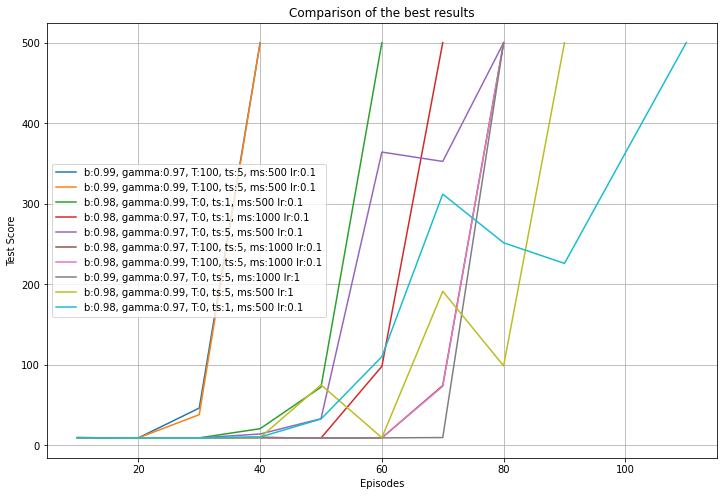

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('epsilon10.png')
plt.show()

In [ ]:
best = sorted(results, key=lambda tup: tup[1])[:5]
print(best)

[('b:0.99, gamma:0.97, T:100, ts:5, ms:500 lr:0.1', 40, [9.6, 9.4, 46.4, 500.0]), ('b:0.99, gamma:0.99, T:100, ts:5, ms:500 lr:0.1', 40, [9.6, 9.4, 38.2, 500.0]), ('b:0.98, gamma:0.99, T:0, ts:1, ms:500 lr:0.1', 60, [9.6, 9.4, 9.4, 20.8, 72.4, 500.0]), ('b:0.98, gamma:0.97, T:0, ts:1, ms:1000 lr:0.1', 70, [9.6, 9.4, 9.4, 9.8, 9.2, 98.2, 500.0]), ('b:0.98, gamma:0.97, T:0, ts:5, ms:500 lr:0.1', 80, [9.6, 9.4, 9.4, 14.2, 33.2, 364.2, 352.6, 500.0])]


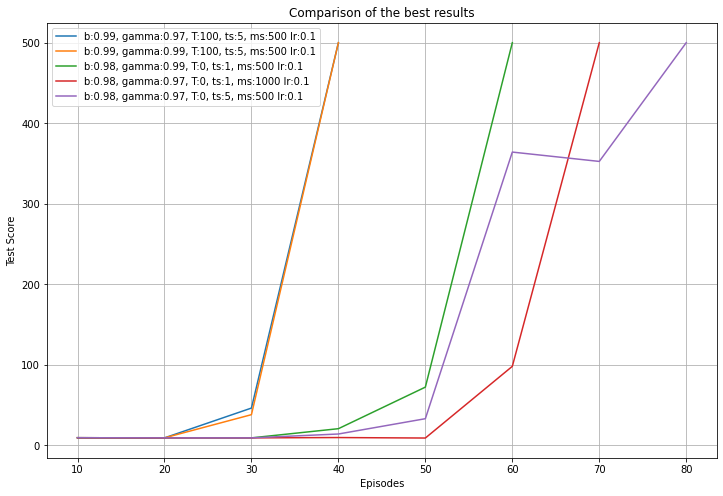

In [ ]:
plt.figure(figsize=(12,8))
for item in best:
    plt.plot(np.arange(10, item[1]+10, 10), item[2], label = item[0])
plt.grid()
plt.title('Comparison of the best results')
plt.xlabel('Episodes')
plt.ylabel('Test Score')
plt.legend()
plt.savefig('epsilon5.png')
plt.show()

### Additional tests

Fastest solution: 40 episodes

In [ ]:
# rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1

score_log, ep_num, policy_net = main(iter=400, gamma=0.97, replay_memory_capacity=10000, lr=0.1, target_net_update_steps=5, 
                                   bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=1, rate=0.99, period=100, msft=500)

Game solved after 40 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()


TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 411
TEST EPISODE 5 - FINAL SCORE: 500
TEST EPISODE 6 - FINAL SCORE: 500
TEST EPISODE 7 - FINAL SCORE: 500
TEST EPISODE 8 - FINAL SCORE: 500
TEST EPISODE 9 - FINAL SCORE: 500
TEST EPISODE 10 - FINAL SCORE: 500
Average test score (over 5 runs): 491.1


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.60.video000009.mp4


Even in this case, the fastest solution is not 100% accurate.

Let's consider another one with more episodes.

In [ ]:
# rate: 0.99, gamma:0.97, period: 100, target_net_update_steps: 5, min_samples_for_training: 500, lr: 0.1

score_log, ep_num, policy_net = main(iter=400, gamma=0.97, replay_memory_capacity=10000, lr=0.1, target_net_update_steps=5, 
                                   bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=1, rate=0.98, period=0, msft=500)

Game solved after 80 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
TEST EPISODE 6 - FINAL SCORE: 500
TEST EPISODE 7 - FINAL SCORE: 500
TEST EPISODE 8 - FINAL SCORE: 500
TEST EPISODE 9 - FINAL SCORE: 500
TEST EPISODE 10 - FINAL SCORE: 500
Average test score (over 5 runs): 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.60.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.60.video000009.mp4


Now the results are 100% accurate and visually we can appreciate a more stable control.

For a more accurate evaluation, let's run 100 test episodes.

In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
# env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        # Visually render the environment
        # env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 100 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
TEST EPISODE 6 - FINAL SCORE: 500
TEST EPISODE 7 - FINAL SCORE: 500
TEST EPISODE 8 - FINAL SCORE: 500
TEST EPISODE 9 - FINAL SCORE: 500
TEST EPISODE 10 - FINAL SCORE: 500
TEST EPISODE 11 - FINAL SCORE: 500
TEST EPISODE 12 - FINAL SCORE: 500
TEST EPISODE 13 - FINAL SCORE: 500
TEST EPISODE 14 - FINAL SCORE: 500
TEST EPISODE 15 - FINAL SCORE: 500
TEST EPISODE 16 - FINAL SCORE: 500
TEST EPISODE 17 - FINAL SCORE: 500
TEST EPISODE 18 - FINAL SCORE: 500
TEST EPISODE 19 - FINAL SCORE: 500
TEST EPISODE 20 - FINAL SCORE: 500
TEST EPISODE 21 - FINAL SCORE: 500
TEST EPISODE 22 - FINAL SCORE: 500
TEST EPISODE 23 - FINAL SCORE: 500
TEST EPISODE 24 - FINAL SCORE: 500
TEST EPISODE 25 - FINAL SCORE: 500
TEST EPISODE 26 - FINAL SCORE: 500
TEST EPISODE 27 - FINAL SCORE: 500
TEST EPISODE 28 - FINAL SCORE: 500
TEST EPISODE 29 - FINAL SCORE

100% accuracy confirmed